[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rinivarg/ReproRehab2024-Pod3/blob/main/Materials/Week%203/Week%203%20-%20Codebook.ipynb)

# Week 3: Clean and Merge Data
<div style="float: right; margin-left: 20px;">
  <img src="https://www.statology.org/wp-content/uploads/2021/12/wideLong1-1.png" alt="Long vs Wide Format Data - Courtesy of Statology" width="600" height="300">
  <br>
  <div style="text-align: right;"><small>Courtesy of <a href="https://www.statology.org" target="_blank">Statology</a></small></div>
</div>
In Week 2, we combined the individual raw data files into one large "parent" file. <br><br>
We can then begin to merge this parent file with other data, such as demographics, so we can progress to eventual analysis.<br>

Right now the parent file is in **long** format, i.e. many varibles nested within it, trial, sub, etc (see figure for wide vs long formats).

For this lesson we are going to look at:
1. Do some basic cleaning
2. Methods to convert it back to wide, and then back to long again
3. Merge with a separate demographic data set
4. Produce an aggregate of the parent data set
5. Use plotting as our "sanity check"

## Clean the entire workspace

In [ ]:
rm(list=ls())

## Load required libraries

In [ ]:
ReqdLibs = c("here","ggplot2","ggthemes","dplyr","tidyr","corrplot","readxl")
invisible(lapply(ReqdLibs, library, character.only = TRUE))

## Theme defaults

In [ ]:
thm = theme(
          strip.text.x=element_text(size=20,face="bold"),
          strip.text.y=element_text(size=20,face="bold"),
          legend.text=element_text(size=16,face="bold"),
          legend.position = "top",
          legend.title=element_text(size=16,face="bold"),
          title =element_text(size=14, face='bold'),
          text = element_text(colour = "black",size=18),
          plot.title = element_text(colour = "black",size = 22, face = "bold"),
          axis.ticks.length = unit(0.3,"cm"),
          axis.line = element_line(colour = "black",size=0.85),
          axis.ticks = element_line(colour = "black",size=0.85),
          axis.text = element_text(colour = "black",size=24),
          axis.title=element_text(size=25))

## Read data
I previously saved the parent data set as a `.csv` I am now reading it in here.

In [ ]:
data.all=read.csv("raw.data.all.csv")

## Start by visualizing
Plots across the time series by subject


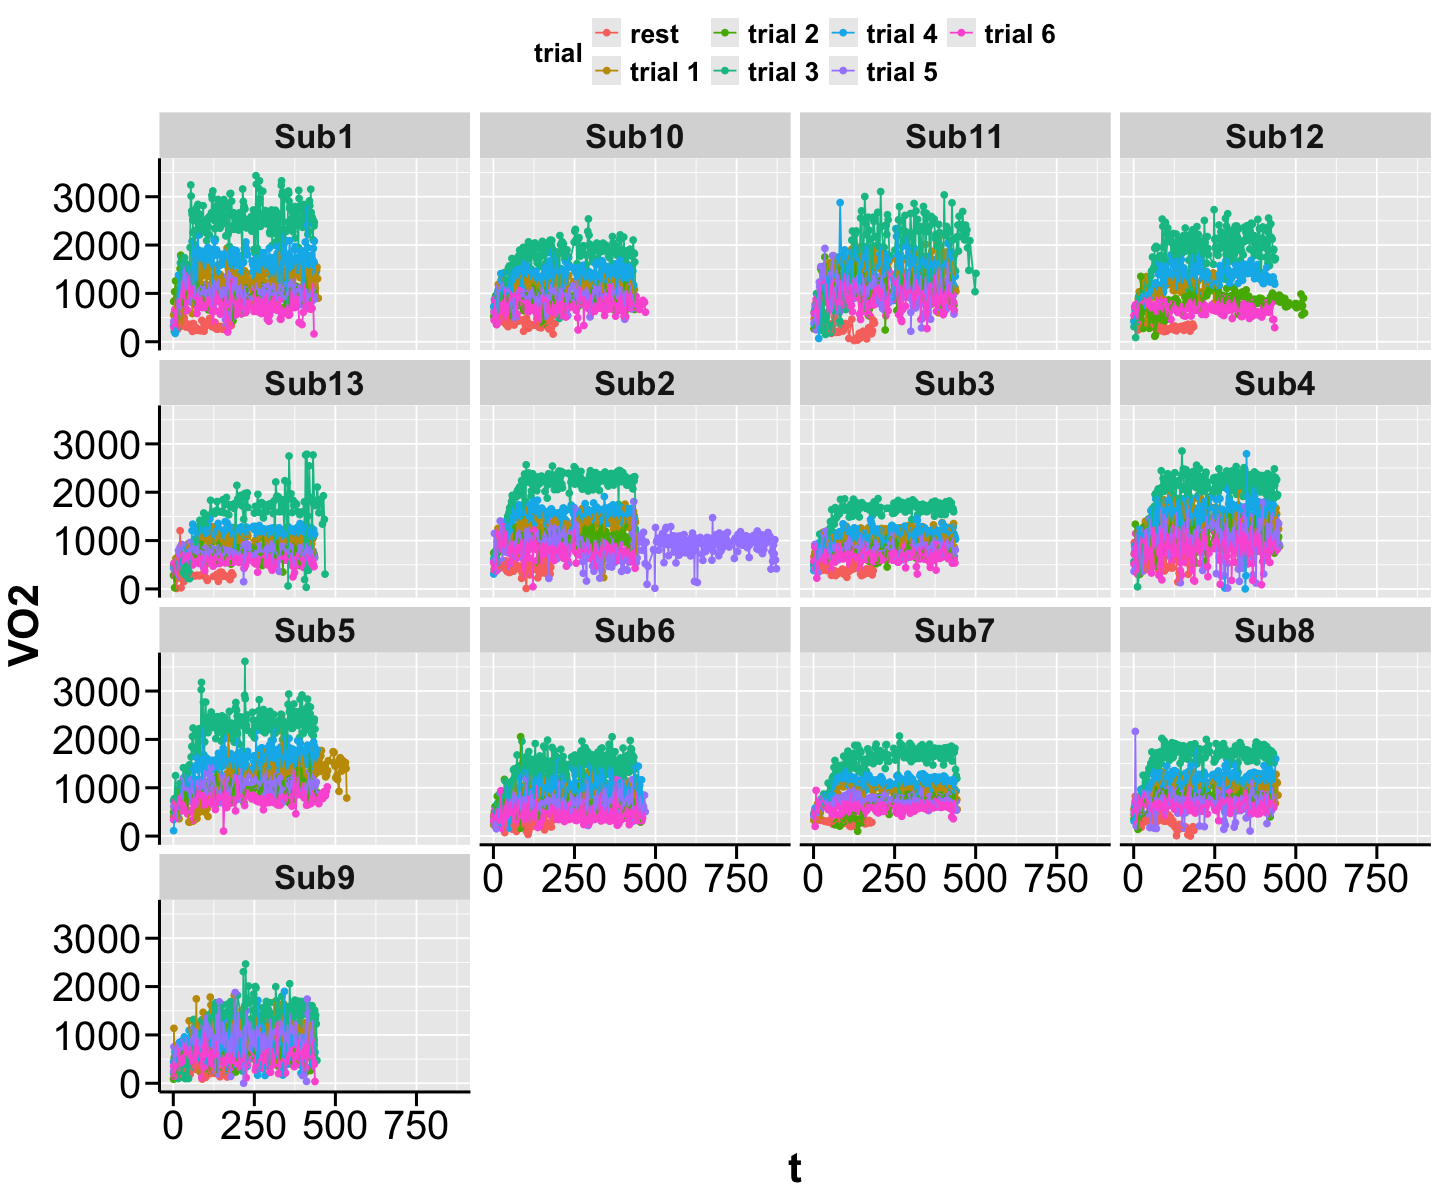

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 10)
ggplot(data.all,aes(x=t,y=VO2,color=trial))+
  geom_point()+
  geom_line()+
  facet_wrap(~Sub) + thm

## Some initial issues
### Issue 1: R naming convention
R still thinks my subjects are listed based on the value of the first integer. We need to change this first so it displays numerically.

In [ ]:
#Right now the Sub variable is a character variable class
class(data.all$Sub)

#But I can convert it to a factor and then set the levels of the factor into
#the order I want them to be.
data.all$Sub=factor(data.all$Sub,levels = c("Sub1","Sub2","Sub3","Sub4",
                                            "Sub5", "Sub6","Sub7","Sub8",
                                            "Sub9","Sub10","Sub11","Sub12",
                                            "Sub13"))
#This is more desireable anyway because any variable of class character is
#implicitly converted to a factor when run through an lm or lme anyway.
class(data.all$Sub)

[1] "character"

[1] "factor"

### visualize again after fixing this issue

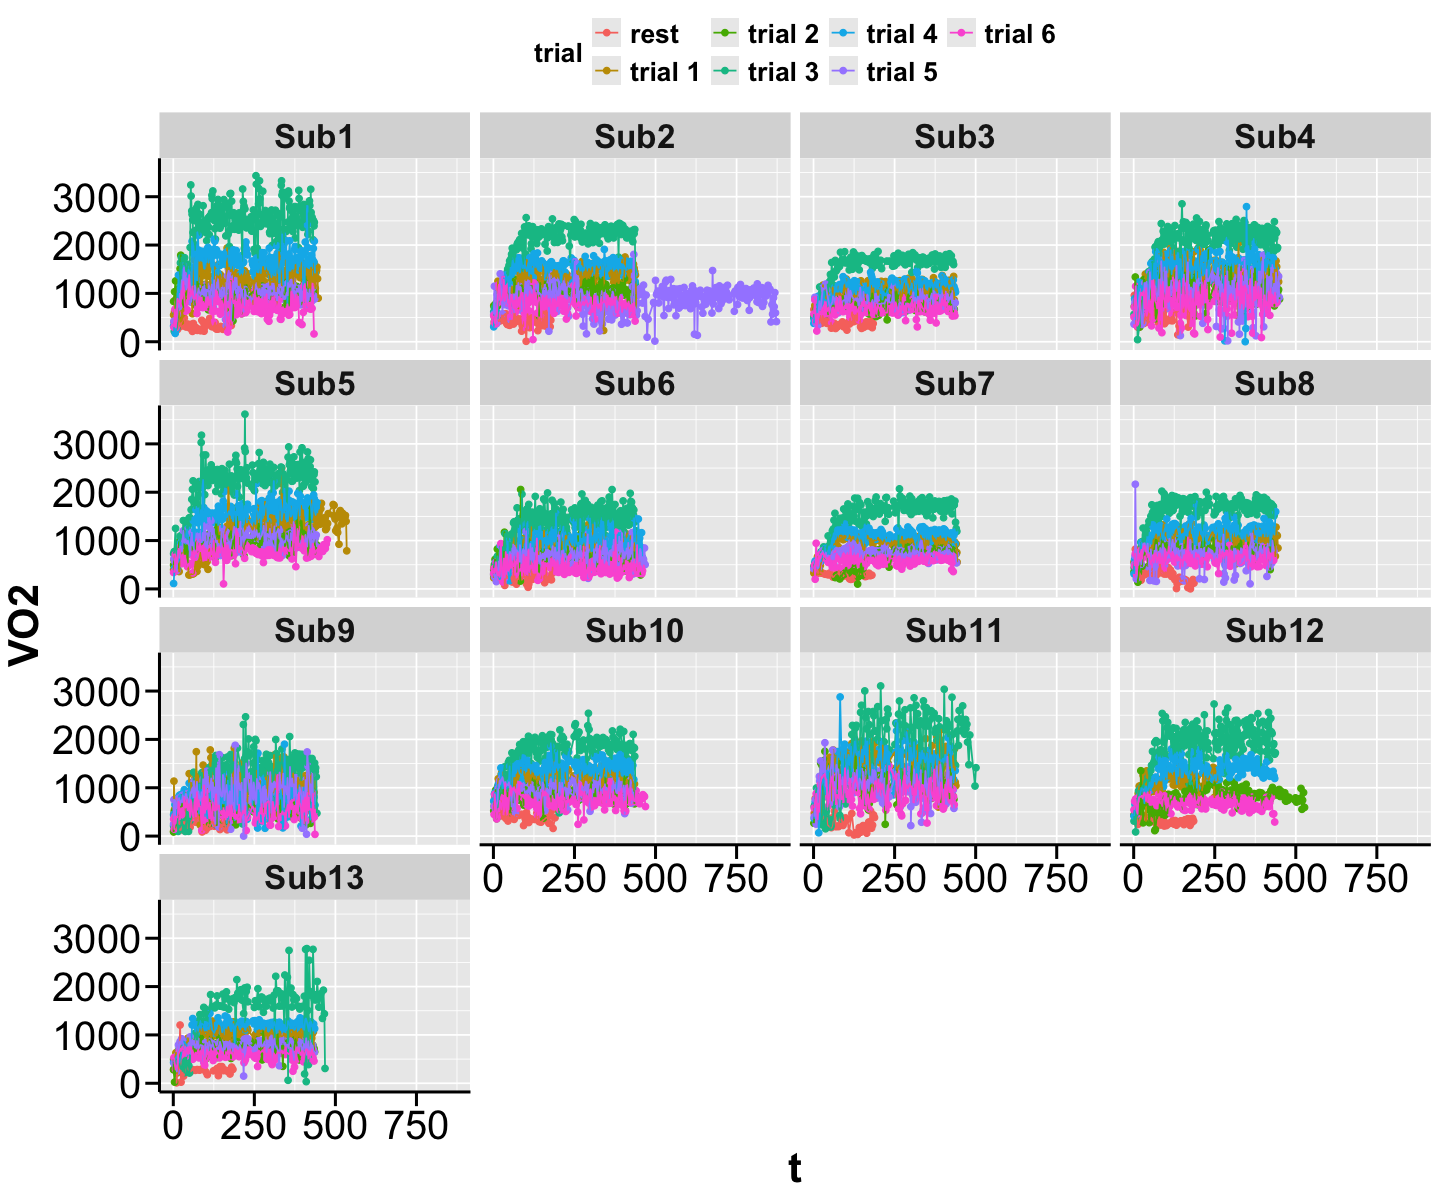

In [ ]:
#Fixed
ggplot(data.all,aes(x=t,y=VO2,color=trial))+
  geom_point()+
  geom_line()+
  facet_wrap(~Sub) + thm

### Issue 2: Inconsistent number of points across trials
Sub 2 took way more time than everyone else on trial 5. I am going to assume
that doesn't warrant throwing that subjects data out, and instead I will just
trim the excess away.<br>

To do that, let's first see how much of the extra to remove. Let's look at how long all subject's trial 5 was. The function aggregate will provide some summary stat based on how I want the dataset aggregated. Here I just want the max time for trial 5 across all subjects. To reduce the output I just index the data.all to only include trial 5. Looks like Sub 2 did 873 seconds, and everyone else did ~440

In [ ]:
aggregate(t~Sub,data.all[data.all$trial=="trial 5",],max)

Sub,t
<fct>,<int>
Sub1,436
Sub2,873
Sub3,437
Sub4,449
Sub5,443
Sub6,468
Sub7,441
Sub8,433
Sub9,433


### trim the data
I am going to remove all t for Sub 2 greater than 440. I am going to use a method called negation `!()`. Here I put in a bunch of boolean arguments into `()` and then preceed it with a `!`. This removes all the rows in my dataset that match these conditions.

Note that if I removed the !() it would only return the trial 5, for Sub2 with t > 440

In [ ]:
data.all2 = data.all[!(data.all$trial=="trial 5" & data.all$Sub=="Sub2" & data.all$t>440),]

### visualize again after fixing the issue

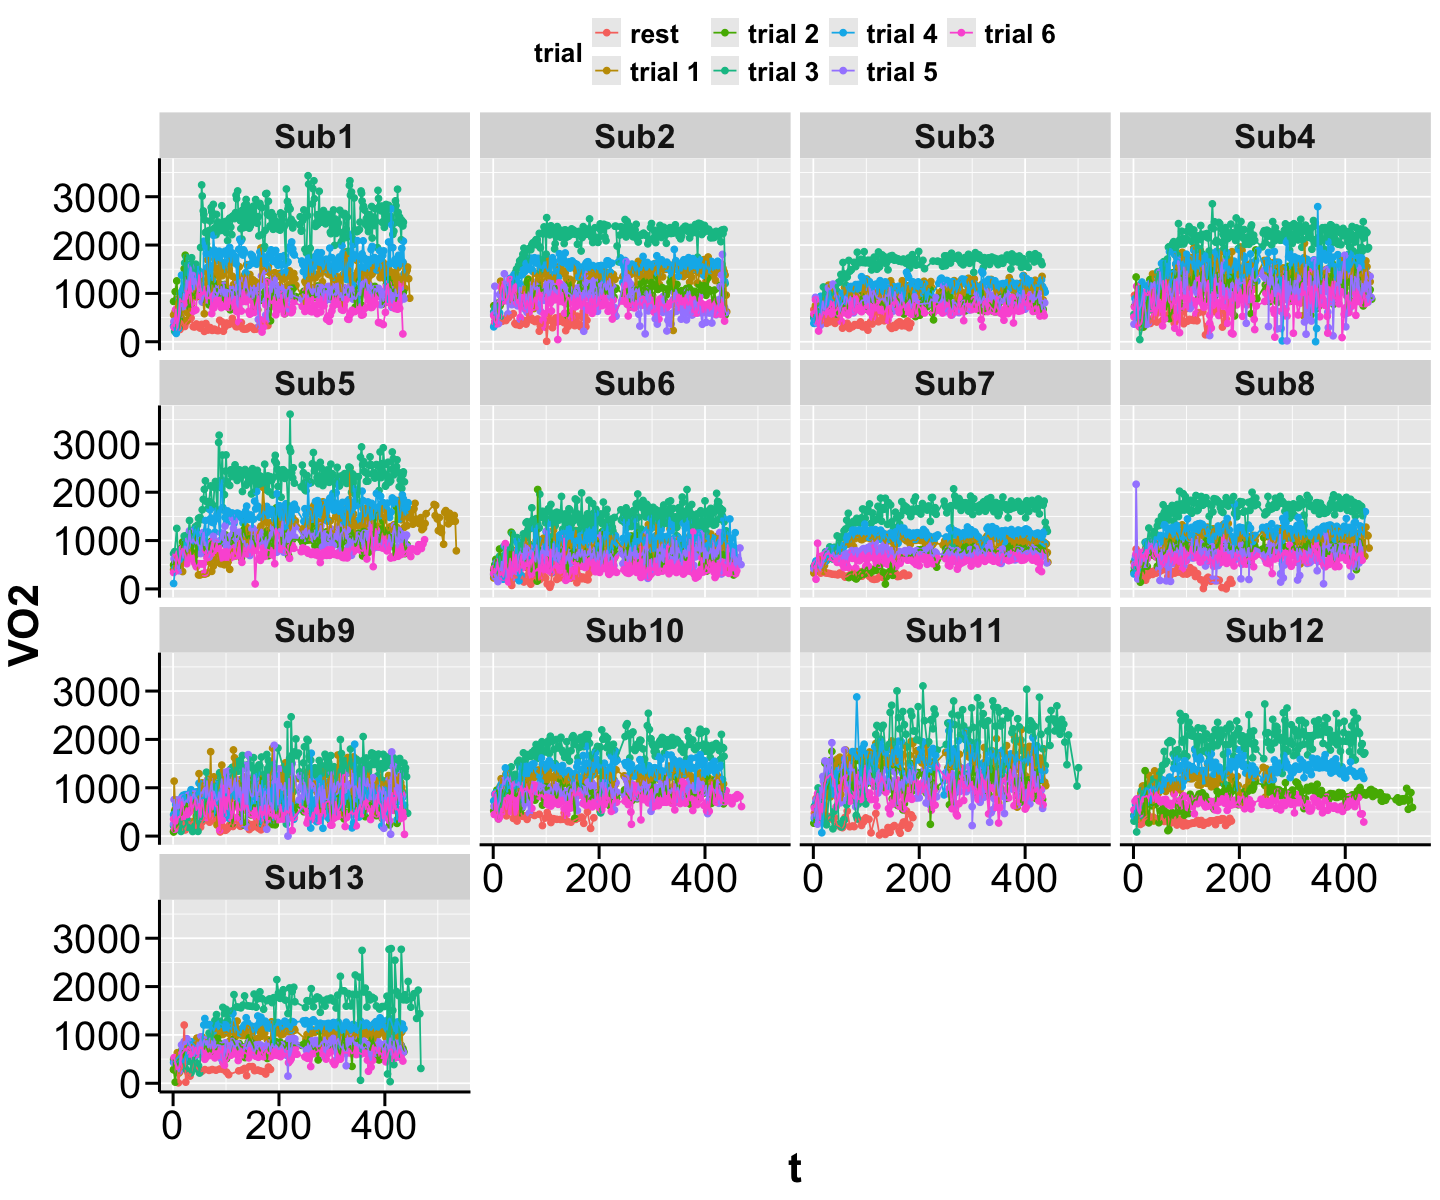

In [ ]:
#Fixed
ggplot(data.all2,aes(x=t,y=VO2,color=trial))+
  geom_point()+
  geom_line()+
  facet_wrap(~Sub) + thm

#I could repeat this process again but let's move on.

## Pivoting: Converting data tables from long to wide format and vice versa

Now I am going to convert the data from long to wide format using the `pivot` functions in the tidyr library. This can be useful if I want to look at correlations between my behavioral variables.<br>
There are various situations where one format is preferable to others. **Note**: when in doubt, remember the tidy data format; each row is an independent observation and each column is a variable of interest. You should <u>never stack numbers along rows of a column that do not share the same units</u>.


### First, I am going to create an aggregate of the data

In [ ]:
data.agg=aggregate(cbind(VO2,Rf,VE,VT)~Sub+trial,data.all2,mean)

#This created a summarized data set across our 4 outcome variables average across all time for each subject for each trial

### Next, let's "pivot" the data frame to a wide format
along the trial variable

In [ ]:
# Using the pivot_wider function from tidyr to create a new variable for each trial
data.agg.w=pivot_wider(data.agg,names_from = trial,
                       values_from = VO2:VT,id_cols = Sub)

### Visualizing correlations across trials using the wider format data

NULL

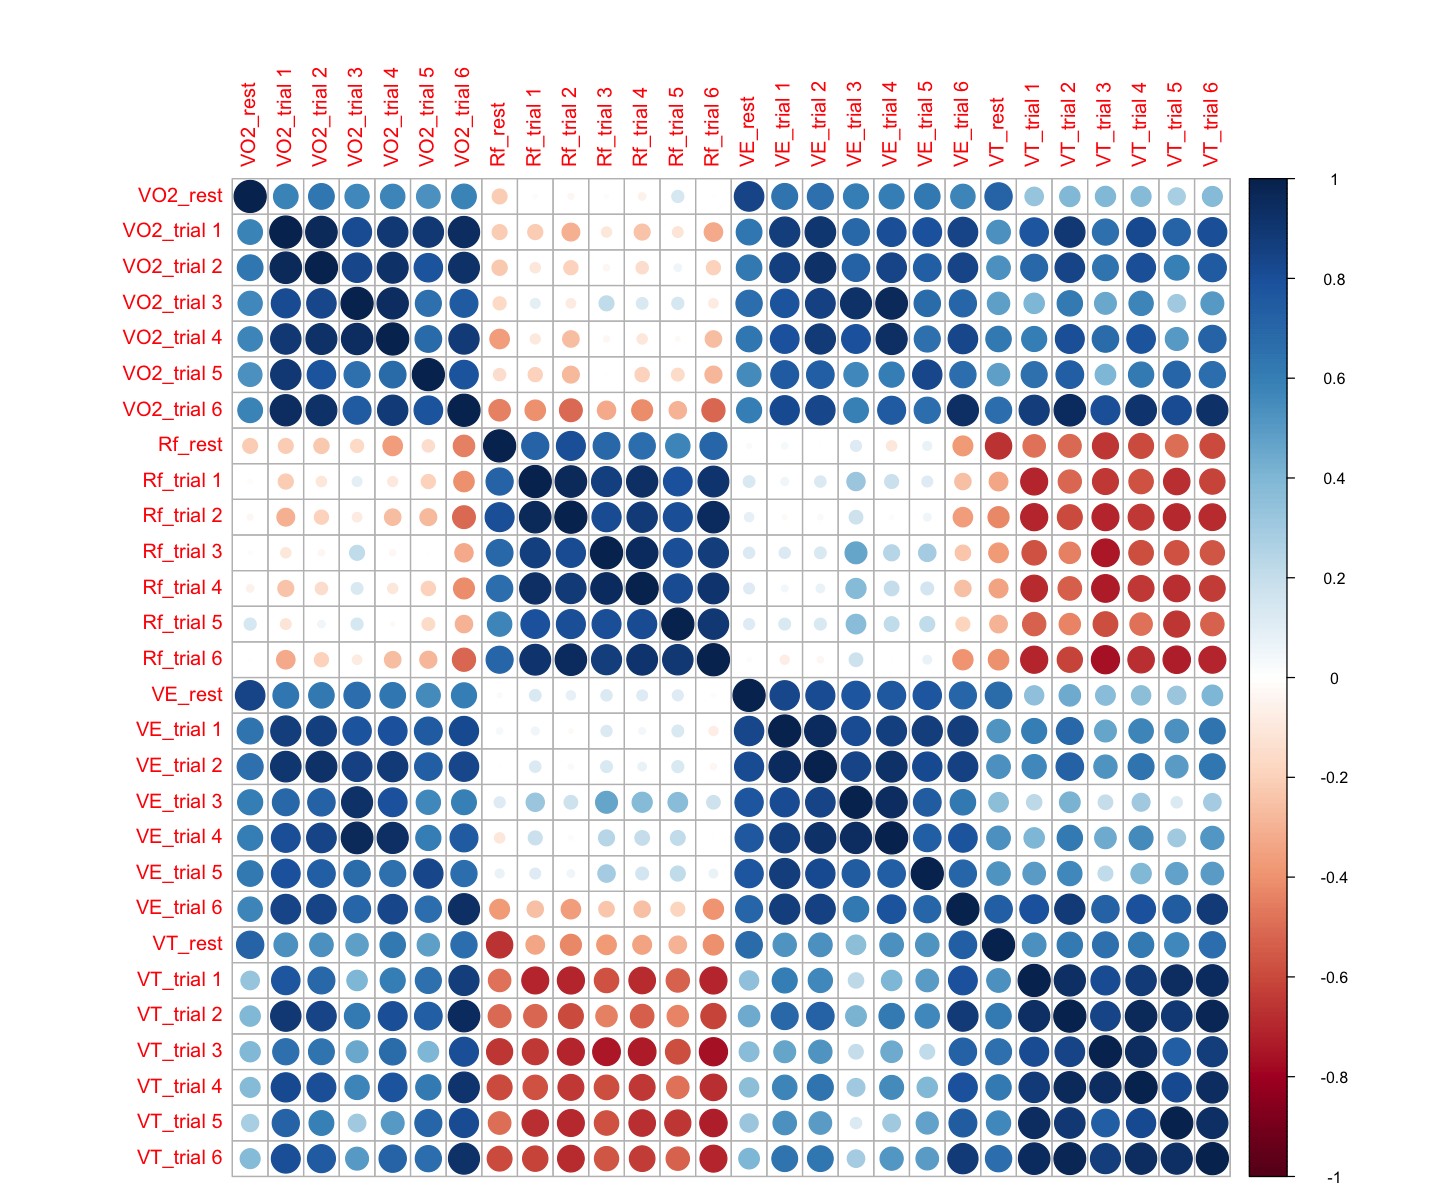

In [ ]:
#create a correlation matrix with only comlete observations,
#Can only include numeric variables.
cmat=cor(data.agg.w[,-1],use="complete.obs")

#Let's visualize the correlations.
corrplot(cmat) + thm

### Now, let's pivot back to the long format

In [ ]:
#Now let's convert our wide dataset back to long, just for fun.
data.agg.l <- pivot_longer(data.agg.w,
                           cols = VO2_rest:`VT_trial 6`,
                           names_to = c(".value", "trial"),
                           names_sep = "_")

## Merge with Demographics
Now that we have our data in a variety of formats we can now merge it with the demographic data.

In [ ]:
demo = read_excel("SubjectInfo.xlsx")

### merging the demo data to the aggregate data in the long format
Note that if the names of the merge variable are different then we have to call that explicitly.

In [ ]:
demo.data=merge(data.agg,demo,by.x="Sub",by.y = "Subject No")

#Have to order the levels of the trial
demo.data$trial=factor(demo.data$trial,levels = c("rest","trial 1","trial 2",
                                                  "trial 3","trial 4","trial 5","trial 6"))

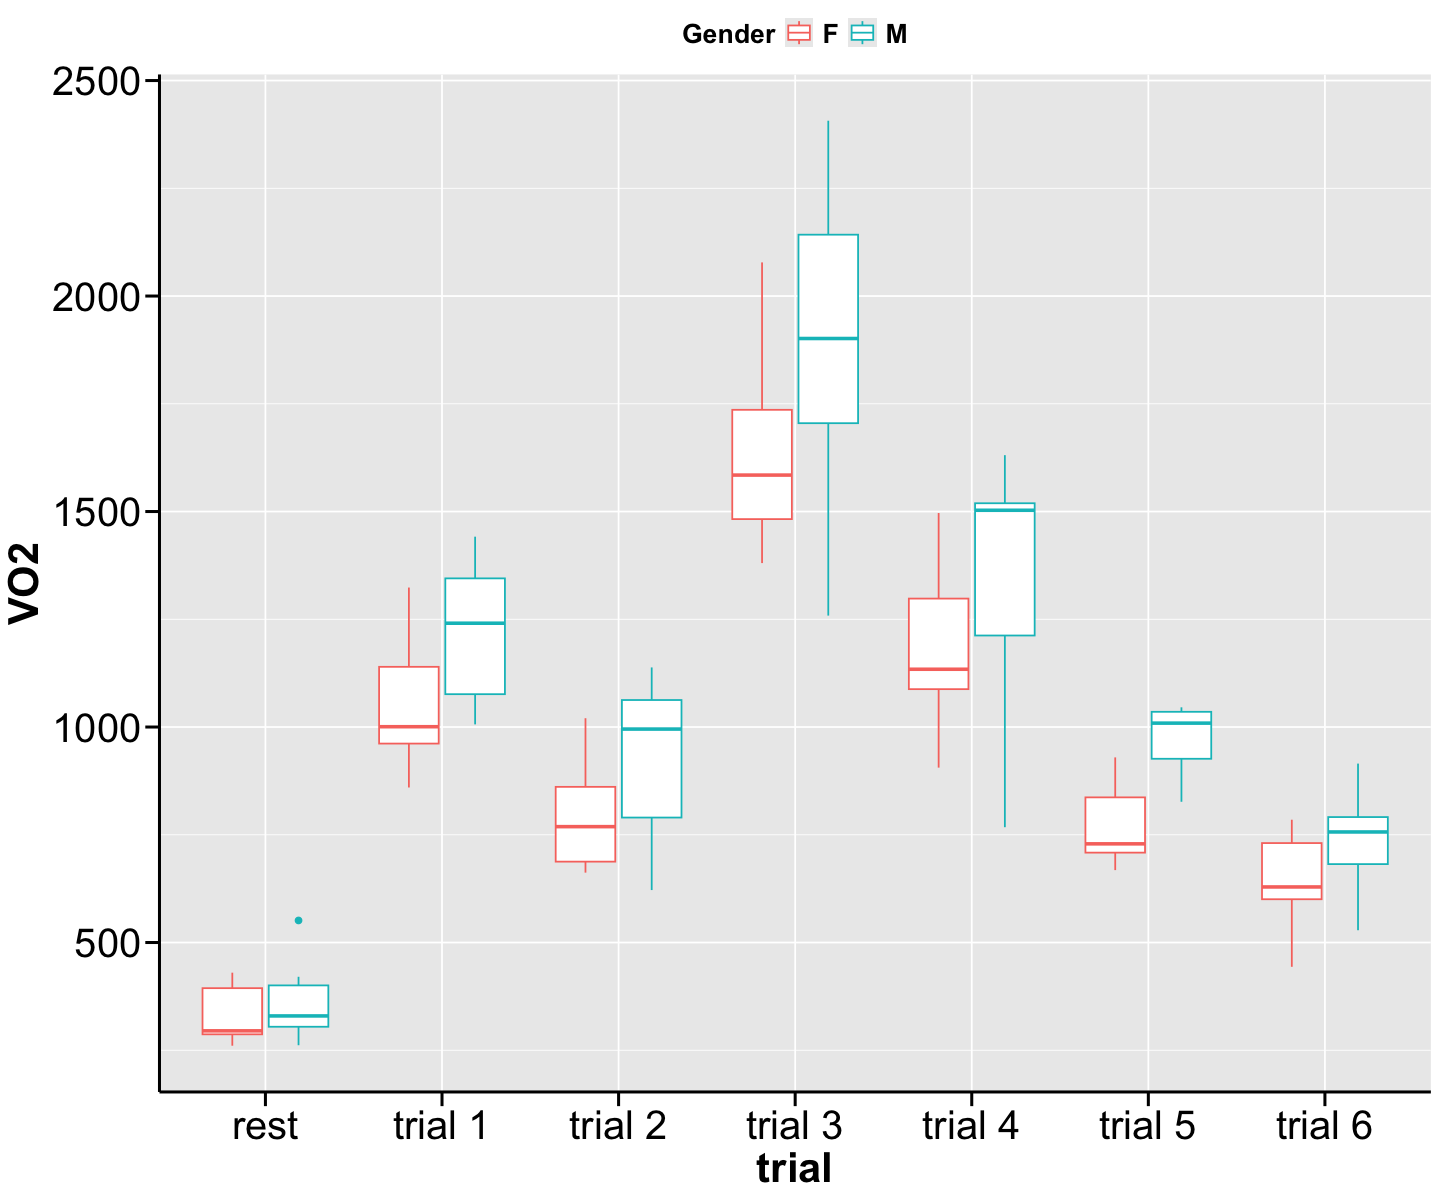

In [ ]:
ggplot(demo.data,aes(x=trial,VO2,color=Gender))+
  geom_boxplot() + thm

### Let's pivot the aggregate data again to look at all variables in one column


In [ ]:
demo.data.var.long=pivot_longer(demo.data,
                               cols = VO2:VT,
                               names_to = "Variable",
                               values_to = "Value")

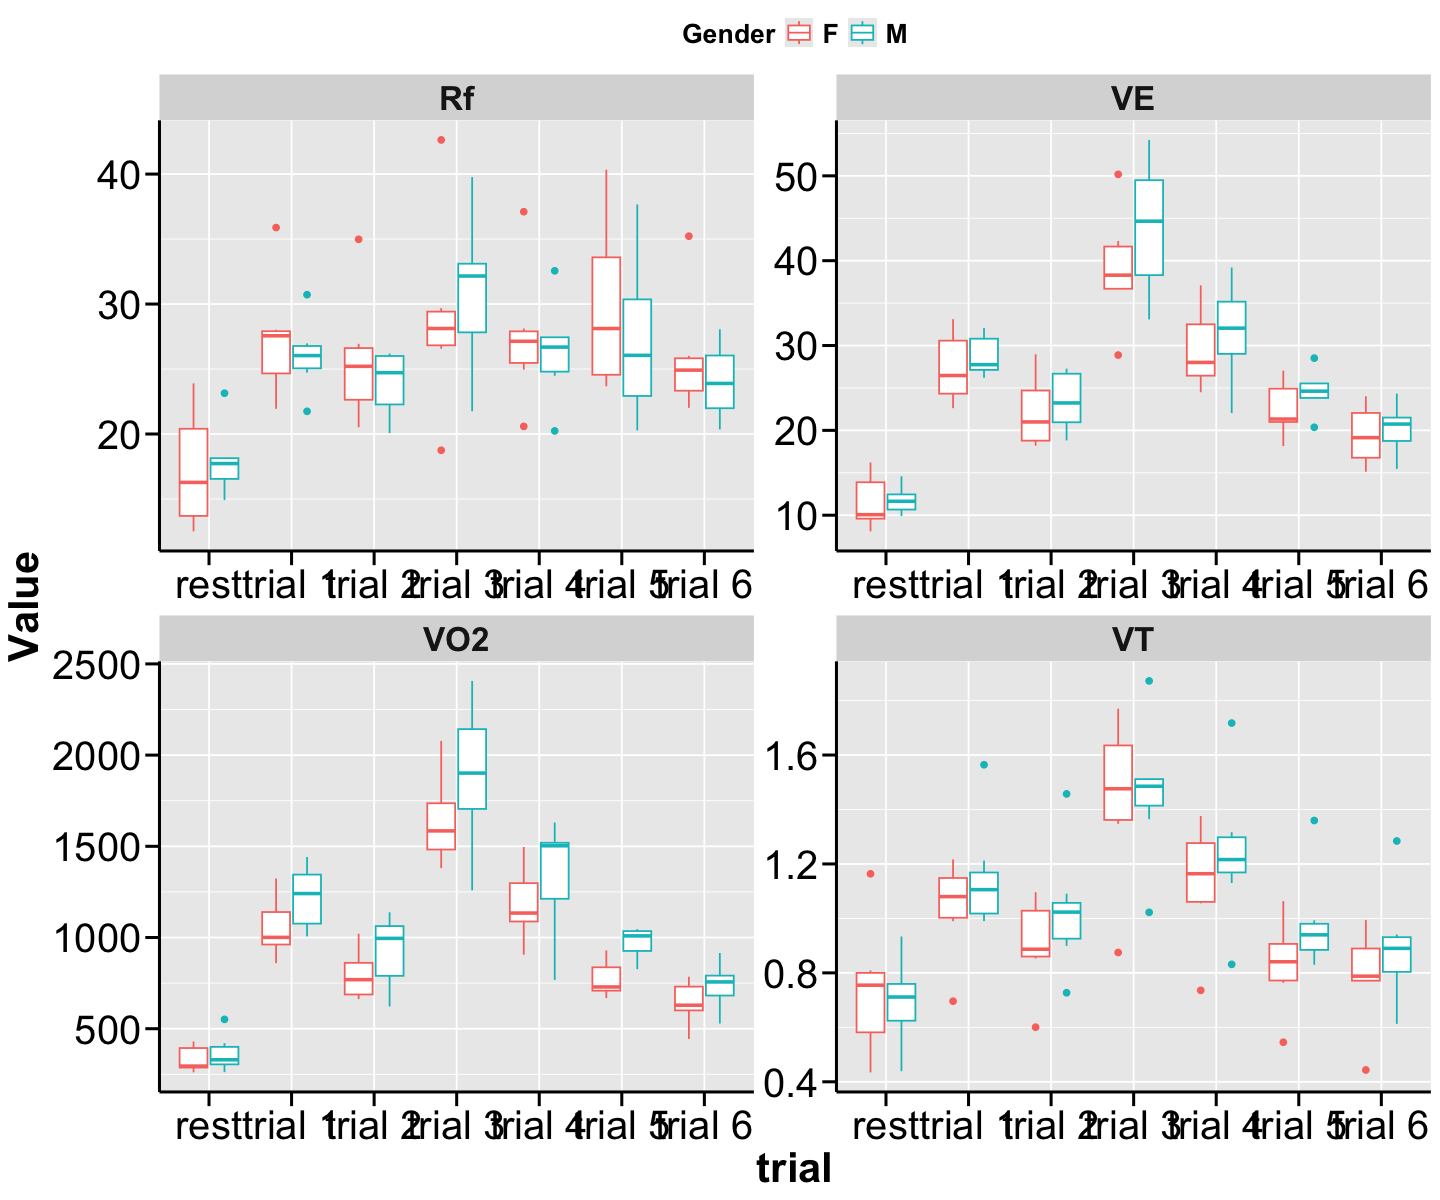

In [ ]:
ggplot(demo.data.var.long,aes(x=trial,Value,color=Gender))+
  geom_boxplot()+
  facet_wrap(~Variable,scales = "free") + thm

## The End